# A Comparison of Classification models for Traffic Signs



## 1. Loading necessary libraries and data

In [1]:
# Loading necessary libraries

# Loading numpy and pandas
import numpy as np 
import pandas as pd 
from numpy.random import seed

# Loading libraries to read images
from PIL import Image
from skimage.io import imread
import cv2

# Loading necessary libraries from sklearns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

# Loading keras for CNN
from keras.utils import to_categorical
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Loading libraries for visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Loading other required libraries
import random
import time
import datetime

Using TensorFlow backend.


In [2]:
# Setting seed

seed(111)

In [3]:
# loading train data

train = pd.read_csv('Train.csv')
train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
# loading test data

test = pd.read_csv('Test.csv')
test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [5]:
# Loading train images and their respective classes

train_x=[]
train_x_vis=[]
for i in train['Path']:
    try:
        img = Image.fromarray(cv2.imread(i), 'RGB')
        train_x.append(np.array(img.resize((32, 32))))
        train_x_vis.append(np.array(img.resize((1,1)))) #For data visualization
    except AttributeError:
        print("Error in loading image")
train_x=np.array(train_x)
train_x_vis=np.array(train_x_vis)
train_y = np.array(train['ClassId'].values)
train_x.shape

(39209, 32, 32, 3)

In [6]:
# Loading train images and their respective classes

test_x=[]
for i in test['Path']:
    try:
        img = Image.fromarray(cv2.imread(i), 'RGB')
        test_x.append(np.array(img.resize((32, 32))))
    except AttributeError:
        print("Error in loading image")
test_x=np.array(test_x)
test_y = np.array(test['ClassId'].values)
test_x.shape

(12630, 32, 32, 3)

## 2. Exploring the data

(<matplotlib.axes._subplots.AxesSubplot at 0x189896c8b88>,
 <matplotlib.image.AxesImage at 0x18989737f88>)

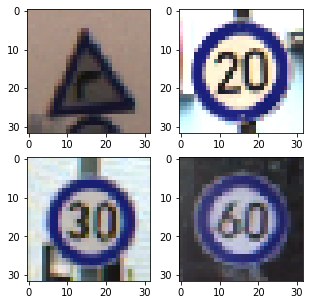

In [7]:
# Loading random images to check if images have been stored in correct format
plot1 = plt
plot1.figure(figsize=(5,5))
plot1.subplot(221), plot1.imshow(train_x[100])
plot1.subplot(222), plot1.imshow(train_x[500])
plot1.subplot(223), plot1.imshow(train_x[1400])
plot1.subplot(224), plot1.imshow(train_x[6000])


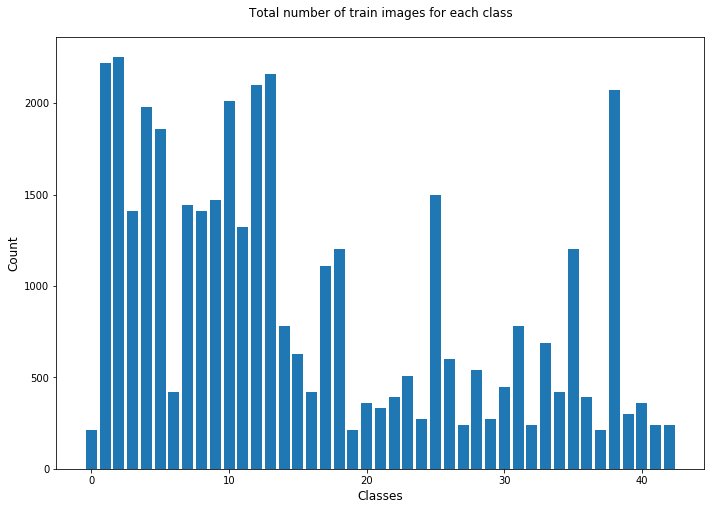

In [8]:
# Number of images per class in train data

unique_class, counts_class = np.unique(train_y, return_counts=True)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.bar(unique_class,counts_class)
ax.set_xlabel('Classes', fontsize='large')
ax.set_ylabel('Count', fontsize='large')
ax.set_title('Total number of train images for each class', fontsize='large', pad=20)
plt.show()

<IPython.core.display.Javascript object>


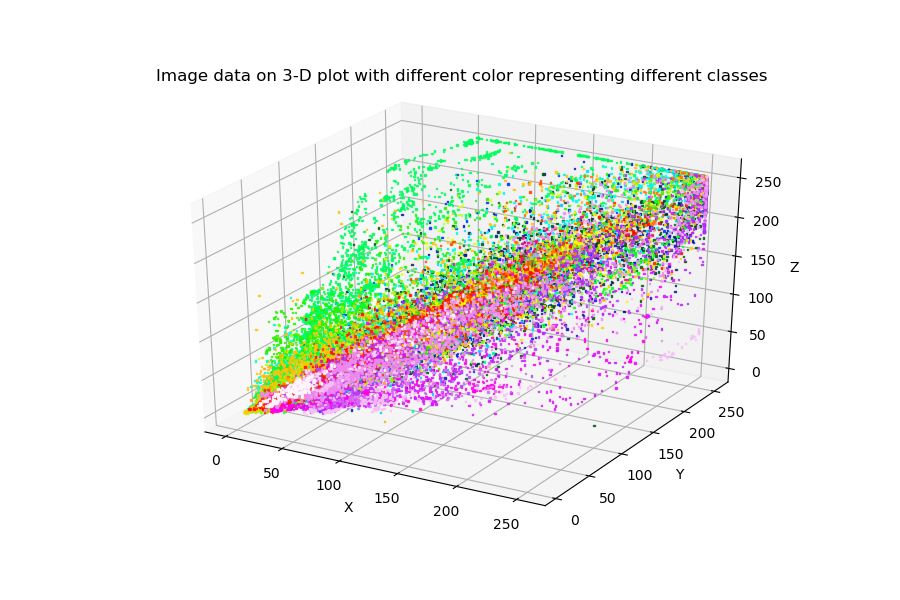

In [9]:
# Visualization of images on 3-D plot with classes

# Creating array for all 3 axes
x=[]
y=[]
z=[]

for i in range(0,train_x_vis.shape[0]):
    temp = train_x_vis[i][0][0]
    x.append(temp[0])
    y.append(temp[1])
    z.append(temp[2])

# Plotting 3-D graph

%matplotlib notebook
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c = train_y,s=1, alpha=0.8,cmap="gist_ncar",marker=',')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Image data on 3-D plot with different color representing different classes', fontsize='large', pad=20)

plt.show()

## 3. Processing Data

In [10]:
# Creating copy of train and test set for cnn

train_x_cnn = np.copy(train_x)
test_x_cnn = np.copy(test_x)

In [11]:
# Dimensions of train and test data

print(train_x.shape,train_y.shape,test_x.shape,test_y.shape) 

(39209, 32, 32, 3) (39209,) (12630, 32, 32, 3) (12630,)


In [12]:
# Resizing images to fit SVM and RF

train_x.resize(39209,3072)
test_x.resize(12630,3072)

In [13]:
# Normaliazing data for SVM and RF

train_x = preprocessing.scale(train_x)
test_x = preprocessing.scale(test_x)

In [14]:
# Normalizing data for CNN

train_x_min = train_x_cnn.min(axis=(0, 1), keepdims=True)
train_x_max = train_x_cnn.max(axis=(0, 1), keepdims=True)
train_x_cnn=(train_x_cnn - train_x_min)/(train_x_max - train_x_min)

test_x_min = test_x_cnn.min(axis=(0, 1), keepdims=True)
test_x_max = test_x_cnn.max(axis=(0, 1), keepdims=True)
test_x_cnn=(test_x_cnn - test_x_min)/(test_x_max - test_x_min)

In [15]:
# Spliting data into train and validation set for CNN

x_train, x_val, y_train, y_val = train_test_split(train_x_cnn, train_y, test_size=0.1, random_state=121)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(35288, 32, 32, 3) (3921, 32, 32, 3) (35288,) (3921,)


In [16]:
#Converting the class labels into categorical variables for CNN

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

## 4. Implementation of Algorithms

In [17]:
# Creating blank dataframe to store model scores

df_scores  = pd.DataFrame(columns = ['Model', 'Score', 'Value'])
df_model = pd.DataFrame(columns = ['Model','Accuracy (%)','Time (mins)'])

### 4.1 Support Vector Machine (SVM)

In [18]:
# Defining SVM model

svm_clf = svm.NuSVC(nu=0.05,kernel='rbf',gamma=0.00001,random_state=121)

In [19]:
# Fitting SVM

tic = time.perf_counter()

svm_clf.fit(train_x, train_y)

toc = time.perf_counter()
m_svm, s_svm = divmod((toc - tic), 60)
time_svm=float(str(str(int(m_svm))+"."+str(int(m_svm))))


In [20]:
# Predicting values for test data

y_pred_svm = svm_clf.predict(test_x)


In [21]:
# Calculating recall, precision, f1 score and accuracy of SVM

recall_svm = metrics.recall_score(test_y, y_pred_svm,average='macro')
df_scores.loc[len(df_scores)] = ["SVM","Recall",recall_svm]

precision_svm = metrics.precision_score(test_y, y_pred_svm,average='macro')
df_scores.loc[len(df_scores)] = ["SVM","Precision",precision_svm]

f1_svm = metrics.f1_score(test_y, y_pred_svm,average='macro')
df_scores.loc[len(df_scores)] = ["SVM","F1",f1_svm]

acc_svm=metrics.accuracy_score(test_y,y_pred_svm)
df_scores.loc[len(df_scores)] = ["SVM","Accuracy",acc_svm]

df_model.loc[len(df_model)] = ["SVM",acc_svm*100,time_svm]
acc_svm

0.8135391923990499

In [22]:
# Classification report for SVM

print("Classification report for SVM classifier %s:\n%s\n"
      % (svm_clf, metrics.classification_report(test_y, y_pred_svm)))

Classification report for SVM classifier NuSVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
      max_iter=-1, nu=0.05, probability=False, random_state=121, shrinking=True,
      tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.83      0.33      0.48        60
           1       0.71      0.88      0.79       720
           2       0.78      0.89      0.83       750
           3       0.64      0.72      0.68       450
           4       0.77      0.77      0.77       660
           5       0.70      0.82      0.75       630
           6       0.77      0.50      0.60       150
           7       0.85      0.74      0.79       450
           8       0.84      0.83      0.84       450
           9       0.92      0.84      0.88       480
          10       0.91      0.94      0.92       660
          11       0.82      0.90      0.86       420
          12    

### 4.2 Random Forest

In [23]:
# Creating list of number of trees

tree_list = [50,100,200,300,500]

In [24]:
y_pred_list=[]
time_rf_list=[]
rf_accuracy=[]
for n in tree_list:
    
    # Defining RF model with 'n' trees
    rf_clf = RandomForestClassifier(n_estimators=n, random_state=121,criterion='entropy')
    tic = time.perf_counter()
    
    # Fitting RF
    rf_clf.fit(train_x, train_y)
    toc = time.perf_counter()
    
    # Predicting values for test data
    y_pred_list.append(rf_clf.predict(test_x))
    
    # Calculating time taken
    m_rf, s_rf = divmod((toc - tic), 60)
    time_rf_list.append(float(str(str(int(m_rf))+"."+str(int(m_rf)))))
    
    # Calculating accuracy of RF
    rf_accuracy.append(metrics.accuracy_score(test_y,rf_clf.predict(test_x)))

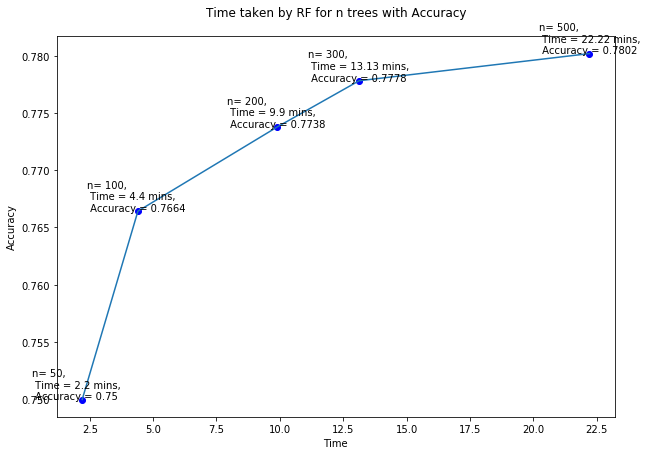

In [25]:
# Plotting time and accuracy for all RF models
# Epochs vs Accuracy
%matplotlib inline
fig = plt.figure(figsize=(10,7))
ax = plt.axes()
ax.plot(time_rf_list,rf_accuracy,'bo')
ax.plot(time_rf_list,rf_accuracy)

ax.set_title('Time taken by RF for n trees with Accuracy',pad=20)
ax.set_xlabel('Time')  
ax.set_ylabel('Accuracy')

for x,y,i in zip(time_rf_list,rf_accuracy,tree_list):

    label = "n= {},\n Time = {} mins,\n Accuracy = {} ".format(i,round(x,4),round(y,4))
    ax.text(x-2,y,label, fontsize=10)
plt.show()  

In [26]:
# Selecting best RF model

rf_clf = RandomForestClassifier(n_estimators=300, random_state=121,criterion='entropy')
y_pred_rf = y_pred_list[3]
time_rf = time_rf_list[3]

acc_rf = rf_accuracy[3]
df_scores.loc[len(df_scores)] = ["RF","Accuracy",acc_rf]

df_model.loc[len(df_model)] = ["RF",acc_rf*100,time_rf]
acc_rf

0.7778305621536026

In [27]:
# Calculating recall, precision and f1 score for RF

recall_rf = metrics.recall_score(test_y, y_pred_rf,average='macro')
df_scores.loc[len(df_scores)] = ["RF","Recall",recall_rf]

precision_rf = metrics.precision_score(test_y, y_pred_rf,average='macro')
df_scores.loc[len(df_scores)] = ["RF","Precision",precision_rf]

f1_rf = metrics.f1_score(test_y, y_pred_rf,average='macro')
df_scores.loc[len(df_scores)] = ["RF","F1",f1_rf]


In [28]:
# Classification report for RF

print("Classification report for RF classifier %s:\n%s\n"
      % (rf_clf, metrics.classification_report(test_y, y_pred_rf)))

Classification report for RF classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=121,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        60
           1       0.67      0.84      0.75       720
           2       0.55      0.70      0.61       750
           3       0.60      0.65      0.62       450
           4       0.68      0.77      0.72       660
           5       0.56      0.59      0.57       630
           6       0.68      0.54      0.60       150
           7       0.69      0.74

### 4.3 Convolution Neural Network (CNN)

In [29]:
# Defining CNN model

cnn_clf = Sequential()
cnn_clf.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=x_train.shape[1:]))
cnn_clf.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
cnn_clf.add(MaxPool2D(pool_size=(2, 2)))
cnn_clf.add(Dropout(rate=0.2))
cnn_clf.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnn_clf.add(MaxPool2D(pool_size=(2, 2)))
cnn_clf.add(Dropout(rate=0.2))
cnn_clf.add(Conv2D(filters=128, kernel_size=(2, 2), activation='relu'))
cnn_clf.add(MaxPool2D(pool_size=(2, 2)))
cnn_clf.add(Dropout(rate=0.2))
cnn_clf.add(Flatten())
cnn_clf.add(Dense(256, activation='relu'))
cnn_clf.add(Dropout(rate=0.2))
cnn_clf.add(Dense(128, activation='relu'))
cnn_clf.add(Dropout(rate=0.2))
cnn_clf.add(Dense(43, activation='softmax'))

In [30]:
# Compilation of the model

cnn_clf.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])


In [31]:
# Fitting CNN

epochs = 10
tic = time.perf_counter()

cnn_fit = cnn_clf.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_data=(x_val, y_val))

toc = time.perf_counter()

m_cnn, s_cnn = divmod((toc - tic), 60)
time_cnn=float(str(str(int(m_cnn))+"."+str(int(m_cnn))))

Train on 35288 samples, validate on 3921 samples
Epoch 1/10
35288/35288 [==============================] - 63s 2ms/step - loss: 2.8052 - accuracy: 0.2202 - val_loss: 1.5500 - val_accuracy: 0.5134
Epoch 2/10
35288/35288 [==============================] - 63s 2ms/step - loss: 1.0232 - accuracy: 0.6657 - val_loss: 0.3498 - val_accuracy: 0.8957
Epoch 3/10
35288/35288 [==============================] - 64s 2ms/step - loss: 0.3885 - accuracy: 0.8762 - val_loss: 0.1448 - val_accuracy: 0.9561
Epoch 4/10
35288/35288 [==============================] - 63s 2ms/step - loss: 0.2244 - accuracy: 0.9292 - val_loss: 0.1003 - val_accuracy: 0.9697
Epoch 5/10
35288/35288 [==============================] - 63s 2ms/step - loss: 0.1611 - accuracy: 0.9497 - val_loss: 0.0605 - val_accuracy: 0.9824
Epoch 6/10
35288/35288 [==============================] - 64s 2ms/step - loss: 0.1210 - accuracy: 0.9623 - val_loss: 0.0507 - val_accuracy: 0.9824
Epoch 7/10
35288/35288 [==============================] - 64s 2ms/ste

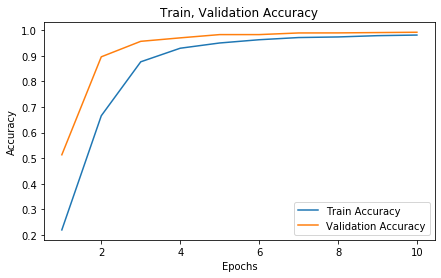

In [32]:
# Epochs vs Accuracy
fig = plt.figure(figsize=(7,4))
ax = plt.axes()
ep=list(range(1, 11))
ax.plot(ep,cnn_fit.history['accuracy'],label="Train Accuracy");
ax.plot(ep,cnn_fit.history['val_accuracy'],label="Validation Accuracy")
ax.set_title('Train, Validation Accuracy')
ax.set_xlabel('Epochs')  
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()  

In [33]:
# Predicting values for test data

y_pred_cnn = cnn_clf.predict_classes(test_x_cnn)


In [34]:
# Calculating and storing recall, precision, f1 score and accuracy of CNN

recall_cnn = metrics.recall_score(test_y, y_pred_cnn,average='macro')
df_scores.loc[len(df_scores)] = ["CNN","Recall",recall_cnn]

precision_cnn = metrics.precision_score(test_y, y_pred_cnn,average='macro')
df_scores.loc[len(df_scores)] = ["CNN","Precision",precision_cnn]

f1_cnn = metrics.f1_score(test_y, y_pred_cnn,average='macro')
df_scores.loc[len(df_scores)] = ["CNN","F1",f1_cnn]

acc_cnn=metrics.accuracy_score(test_y,y_pred_cnn)
df_scores.loc[len(df_scores)] = ["CNN","Accuracy",acc_cnn]

df_model.loc[len(df_model)] = ["CNN",acc_cnn*100,time_cnn]
acc_cnn

0.9673792557403009

In [35]:
# Classification report for CNN

print("Classification report for CNN classifier %s:\n%s\n"
      % (cnn_clf, metrics.classification_report(test_y, y_pred_cnn)))

Classification report for CNN classifier <keras.engine.sequential.Sequential object at 0x0000018998CCBA48>:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96        60
           1       0.94      0.99      0.96       720
           2       0.97      0.98      0.98       750
           3       0.99      0.97      0.98       450
           4       0.99      0.98      0.99       660
           5       0.97      0.95      0.96       630
           6       1.00      0.89      0.94       150
           7       0.99      0.97      0.98       450
           8       0.97      0.96      0.97       450
           9       0.98      0.99      0.99       480
          10       1.00      1.00      1.00       660
          11       0.96      0.94      0.95       420
          12       0.98      0.95      0.96       690
          13       0.99      1.00      0.99       720
          14       0.99      1.00      1.00       270
          15       0.94    

In [36]:
df_model

,Model,Accuracy (%),Time (mins)
0,SVM,81.353919,32.32
1,RF,77.783056,13.13
2,CNN,96.737926,10.10


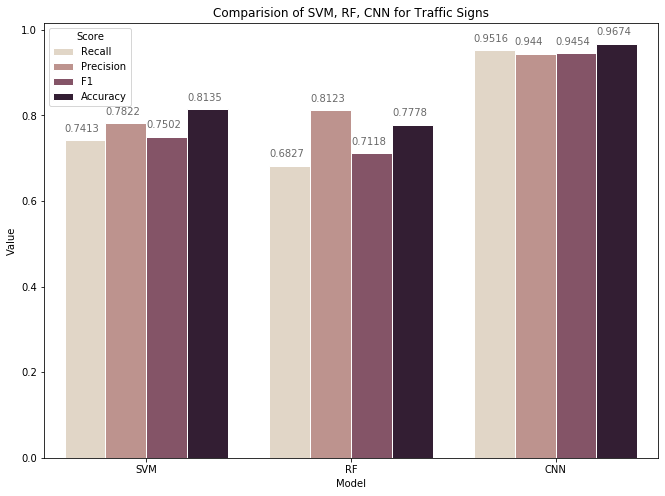

In [37]:

fig = plt.figure(figsize=(11,8))
ax = plt.axes()
ax = sns.barplot(x="Model", y="Value", hue="Score", data=df_scores, palette="ch:.25",edgecolor="1")
ax.set_title('Comparision of SVM, RF, CNN for Traffic Signs')

for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+.02,str(round((i.get_height()), 4)), fontsize=10,color='dimgrey')
plt.show() 

In [ ]:
# Saving CNN model

cnn_clf.save('cnn_classifier.h5')